In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import missingno as msno

from keras.layers import Input, Dense, concatenate, Embedding, LSTM, Conv1D, Flatten, MaxPooling1D
from keras.layers import Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1, l2

import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('job_skills.csv')
df.head(3)

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...


In [3]:
df.dropna(inplace=True)

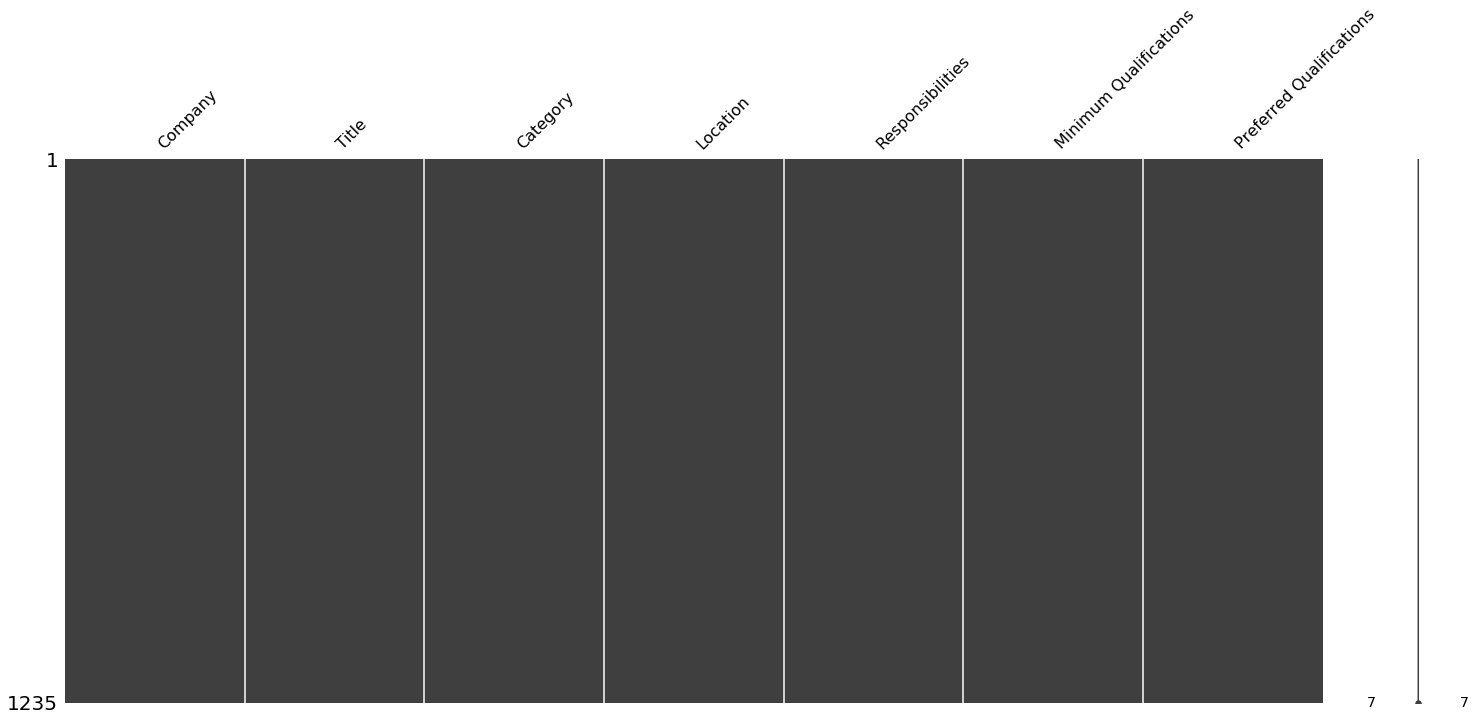

In [4]:
msno.matrix(df)

In [5]:
def combine(i):
    return ' '.join(df.iloc[i,-3:]).replace("\n","")

In [6]:
X = [combine(i) for i in range(df.shape[0])]
y = df['Category']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify=y, random_state=42)
print([len(i) for i in [X_train, X_test, y_train, y_test]])

[1049, 186, 1049, 186]


# Functional model with Multi-inputs

In [8]:
cnt = CountVectorizer(stop_words=None)
cnt.fit(X_train)
len(cnt.vocabulary_)

5598

In [9]:
vocab_size = 5598

In [10]:
lbl = LabelEncoder()
y_train_lbl = lbl.fit_transform(y_train)

(1049, 300)

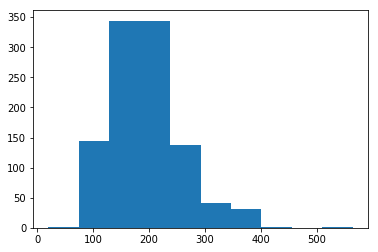

In [11]:
t = Tokenizer(num_words=vocab_size)
t.fit_on_texts(X_train)
seq = t.texts_to_sequences(X_train)
plt.hist([len(i) for i in seq])
X_train_pad = pad_sequences(seq, maxlen=300, truncating='post', padding='post')
X_train_pad.shape

In [12]:
out_dims = len(np.unique(y_train))
inp_dims = X_train_pad.shape[1]

In [27]:
inp = Input((inp_dims,))
embed_out = Embedding(vocab_size, 256, input_length=inp_dims)(inp)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(embed_out)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(out_dims, activation='softmax')(x)

model = Model(inp, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 256)          1433088   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 298, 32)           24608     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 149, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4768)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                305216    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(X_train_pad, y_train_lbl,      
          epochs=10, 
          batch_size=128, 
          validation_split=0.2, 
          verbose=1,
          callbacks = [time_callback])

Train on 839 samples, validate on 210 samples
Epoch 1/10
839/839 [==============================] - 2s 2ms/step - loss: 3.0337 - acc: 0.0954 - val_loss: 2.8605 - val_acc: 0.1429
Epoch 2/10
839/839 [==============================] - 1s 1ms/step - loss: 2.9234 - acc: 0.1287 - val_loss: 2.8377 - val_acc: 0.2000
Epoch 3/10
839/839 [==============================] - 1s 2ms/step - loss: 2.8025 - acc: 0.1478 - val_loss: 2.7609 - val_acc: 0.1857
Epoch 4/10
839/839 [==============================] - 1s 1ms/step - loss: 2.6730 - acc: 0.1871 - val_loss: 2.6681 - val_acc: 0.1952
Epoch 5/10
839/839 [==============================] - 1s 2ms/step - loss: 2.5864 - acc: 0.2169 - val_loss: 2.5991 - val_acc: 0.2429
Epoch 6/10
839/839 [==============================] - 1s 1ms/step - loss: 2.4508 - acc: 0.2503 - val_loss: 2.4945 - val_acc: 0.2905
Epoch 7/10
839/839 [==============================] - 1s 1ms/step - loss: 2.3446 - acc: 0.2813 - val_loss: 2.3749 - val_acc: 0.3143
Epoch 8/10
839/839 [==========

In [29]:
from keras.callbacks import Callback

In [35]:
#Callback class for time history (picked up this solution directly from stackoverflow)

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

In [61]:
def get_average_layer_train_time(epochs):
    
    #Loop through each layer setting it Trainable and others as non trainable
    results = []
    for i in range(len(model.layers)):
        
        layer_name = model.layers[i].name    #storing name of layer for printing layer
        
        #Setting all layers as non-Trainable
        for layer in model.layers:
            layer.trainable = False
            
        #Setting ith layers as trainable
        model.layers[i].trainable = True
        
        #Compile
        model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
        
        #Fit on a small number of epochs with callback that records time for each epoch
        model.fit(X_train_pad, y_train_lbl,      
              epochs=epochs, 
              batch_size=128, 
              validation_split=0.2, 
              verbose=0,
              callbacks = [time_callback])
        
        results.append(np.average(time_callback.times))
        #Print average of the time for each layer
        print(f"{layer_name}: Approx (avg) train time for {epochs} epochs = ", np.average(time_callback.times))
    return results

In [62]:
runtimes = get_average_layer_train_time(5)

input_2: Approx (avg) train time for 5 epochs =  0.4942781925201416
embedding_2: Approx (avg) train time for 5 epochs =  0.9014601230621337
conv1d_2: Approx (avg) train time for 5 epochs =  0.822748851776123
max_pooling1d_2: Approx (avg) train time for 5 epochs =  0.479401683807373
flatten_2: Approx (avg) train time for 5 epochs =  0.47864508628845215
dense_4: Approx (avg) train time for 5 epochs =  0.5149370670318604
dropout_3: Approx (avg) train time for 5 epochs =  0.48329877853393555
dense_5: Approx (avg) train time for 5 epochs =  0.4966880321502686
dropout_4: Approx (avg) train time for 5 epochs =  0.48073616027832033
dense_6: Approx (avg) train time for 5 epochs =  0.49605698585510255


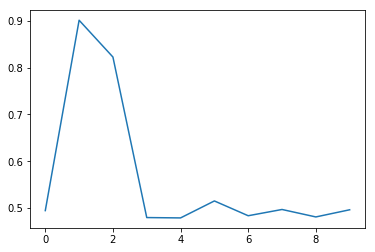

In [66]:
plt.plot(runtimes)

In [20]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(X_train_pad, y_train_lbl,      
          epochs=100, 
          batch_size=128, 
          validation_split=0.2, 
          verbose=1)

Train on 839 samples, validate on 210 samples
Epoch 1/100
839/839 [==============================] - 2s 2ms/step - loss: 3.1185 - acc: 0.0858 - val_loss: 3.0276 - val_acc: 0.0905
Epoch 2/100
839/839 [==============================] - 1s 1ms/step - loss: 2.9690 - acc: 0.1144 - val_loss: 2.9572 - val_acc: 0.0905
Epoch 3/100
839/839 [==============================] - 1s 1ms/step - loss: 2.8670 - acc: 0.1454 - val_loss: 2.8469 - val_acc: 0.1190
Epoch 4/100
839/839 [==============================] - 1s 1ms/step - loss: 2.7308 - acc: 0.1871 - val_loss: 2.7159 - val_acc: 0.1476
Epoch 5/100
839/839 [==============================] - 1s 1ms/step - loss: 2.5868 - acc: 0.2253 - val_loss: 2.6455 - val_acc: 0.1762
Epoch 6/100
839/839 [==============================] - 1s 1ms/step - loss: 2.4815 - acc: 0.2610 - val_loss: 2.5310 - val_acc: 0.1857
Epoch 7/100
839/839 [==============================] - 1s 1ms/step - loss: 2.3753 - acc: 0.2551 - val_loss: 2.4899 - val_acc: 0.2381
Epoch 8/100
839/839 [==

Epoch 62/100
839/839 [==============================] - 1s 1ms/step - loss: 0.6626 - acc: 0.7795 - val_loss: 1.5813 - val_acc: 0.6476
Epoch 63/100
839/839 [==============================] - 1s 1ms/step - loss: 0.5671 - acc: 0.8105 - val_loss: 1.6798 - val_acc: 0.6238
Epoch 64/100
839/839 [==============================] - 1s 1ms/step - loss: 0.5627 - acc: 0.8093 - val_loss: 1.7537 - val_acc: 0.6048
Epoch 65/100
839/839 [==============================] - 1s 1ms/step - loss: 0.5747 - acc: 0.7998 - val_loss: 1.7162 - val_acc: 0.6095
Epoch 66/100
839/839 [==============================] - 1s 1ms/step - loss: 0.5356 - acc: 0.8164 - val_loss: 1.8273 - val_acc: 0.6048
Epoch 67/100
839/839 [==============================] - 1s 1ms/step - loss: 0.5941 - acc: 0.7986 - val_loss: 1.6188 - val_acc: 0.6429
Epoch 68/100
839/839 [==============================] - 1s 1ms/step - loss: 0.5460 - acc: 0.8248 - val_loss: 1.7828 - val_acc: 0.6190
Epoch 69/100
839/839 [==============================] - 1s 1ms

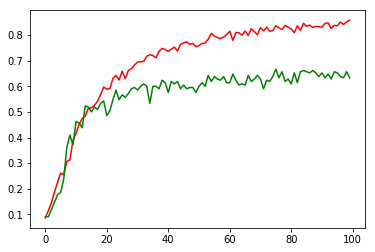

In [21]:
plt.plot(model.history.history.get('acc'),'r')
plt.plot(model.history.history.get('val_acc'),'g')

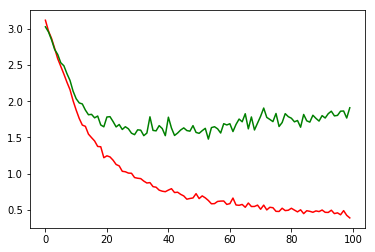

In [22]:
plt.plot(model.history.history.get('loss'),'r')
plt.plot(model.history.history.get('val_loss'),'g')

In [ ]:
weights = model.layers[1]

In [ ]:
embedding_weights = weights.get_weights()[0]

In [ ]:
embedding_weights.shape

In [ ]:
t.index_word

In [ ]:
embedding_weights[27+1]

In [ ]:
dots = np.dot(embedding_weights, embedding_weights.T)
dots.shape

In [ ]:
def get_nearest_words(word,num = 10):
    pos = t.word_index.get(word)
    row = dots[pos-1]
    sorted_indexes = np.argsort(row)
    tops = sorted_indexes[-num:]
    bottoms = sorted_indexes[:num]
    
    
    top_words = [t.index_word.get(i) for i in tops]
    bottom_words = [t.index_word.get(i) for i in bottoms]
    
    return top_words, bottom_words

In [ ]:
t.index_word

In [ ]:
get_nearest_words('coding')